In [1]:
# Add project path to the PYTHONPATH

import os
import sys
import numpy as np
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
import pickle

In [3]:
from time import time

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

## Load Test Set

Load the test dataset

In [6]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rmohashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
dataset = Dataset('../datasets/semeval/testset.csv')
dataset.load()
dataset.preprocess_texts(stemming=True)
data = dataset.cleaned_data.copy()

Time to clean up: 2.32 sec


In [8]:
x_test = data.text
y_test = data.label

In [9]:
import seaborn as sns

[Text(0, 0.5, 'Número de tweets'), Text(0.5, 0, 'Rótulo')]

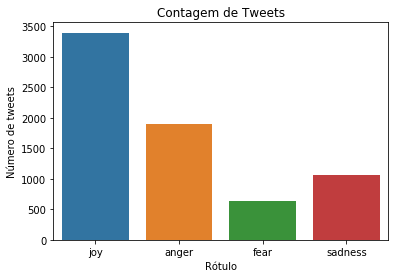

In [10]:
ax = sns.countplot(x='label', data=data)
ax.set_title('Contagem de Tweets')
ax.set(xlabel='Rótulo', ylabel='Número de tweets')

In [11]:
print(len(data[data.label == 'joy']))
print(len(data[data.label == 'anger']))
print(len(data[data.label == 'fear']))
print(len(data[data.label == 'sadness']))

3397
1892
630
1059


## Load Model

Load the trained naive bayes - sentiment analysis model

In [12]:
filepath = Path('../models/emotion_recognition/nb_model.pickle').resolve()
with filepath.open('rb') as file:
    model = pickle.load(file)

## Naive Bayes

In [13]:
from sklearn.metrics import classification_report

In [14]:
results = model.predict(x_test)
print(classification_report(y_test, results, digits=4))

              precision    recall  f1-score   support

       anger     0.7554    0.6971    0.7251      1892
        fear     0.5399    0.5476    0.5437       630
         joy     0.8797    0.7165    0.7897      3397
     sadness     0.4283    0.7384    0.5421      1059

    accuracy                         0.6993      6978
   macro avg     0.6508    0.6749    0.6502      6978
weighted avg     0.7468    0.6993    0.7124      6978



In [15]:
from sklearn.preprocessing import LabelBinarizer

In [16]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

Confusion matrix
[[0.69714588 0.04704017 0.0782241  0.17758985]
 [0.12063492 0.54761905 0.13492063 0.1968254 ]
 [0.06888431 0.04268472 0.71651457 0.1719164 ]
 [0.11048159 0.05665722 0.09442871 0.73843248]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c0eb54438>)

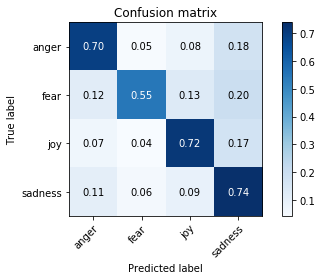

In [17]:
nb_y_test = label_binarizer.transform(y_test).argmax(axis=1)
nb_results = label_binarizer.transform(results).argmax(axis=1)
plot_confusion_matrix(nb_y_test, nb_results, label_binarizer.classes_, normalize=True)

## Neural Networks

In [18]:
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

/home/rmohashi/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rmohashi/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rmohashi/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rmohashi/miniconda3/lib/python3.7/site-packages/tensorflow/python/f

In [19]:
from emotion_recognition.models.lstm_model import lstm_model
from emotion_recognition.models.cnn_model import cnn_model
from emotion_recognition.models.lstm_conv_model import lstm_conv_model

In [20]:
tokenizer_path = Path('/home/rmohashi/hd/emotion/tokenizer.pickle').resolve()

In [21]:
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

In [22]:
sequences = [text.split() for text in data.text]
list_tokenized = tokenizer.texts_to_sequences(sequences)

In [23]:
encoder_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/encoder.pickle').resolve()
with encoder_path.open('rb') as file:
    encoder = pickle.load(file)

In [24]:
y_test = encoder.transform(y_test).argmax(axis=1)

### 100d - W2V

In [25]:
input_dim = len(tokenizer.word_index) + 1

In [26]:
input_length = 30
embedding_dim = 100

#### LSTM

In [27]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/lstm_100_30/lstm_100_30_05-0.5112.h5').resolve()

In [32]:
start = time()
model = lstm_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 2.17 secs
              precision    recall  f1-score   support

           0     0.7467    0.7246    0.7355      1892
           1     0.4472    0.7063    0.5477       630
           2     0.8705    0.7321    0.7953      3397
           3     0.5457    0.6648    0.5994      1059

    accuracy                         0.7175      6978
   macro avg     0.6525    0.7070    0.6695      6978
weighted avg     0.7494    0.7175    0.7270      6978



In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### CNN

In [ ]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/cnn_100_30/cnn_100_30_06-0.4952.h5').resolve()

In [ ]:
model = cnn_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### LSTM-CNN

In [ ]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/lstm_conv_100_30/lstm_conv_100_30_18-0.5061.h5').resolve()

In [ ]:
model = lstm_conv_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

### 100d

In [35]:
input_dim = tokenizer.num_words
embedding_dim = 100

#### LSTM

In [36]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/lstm_100_30_ne/lstm_100_30_01-0.5095.h5').resolve()

In [42]:
start = time()
model = lstm_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 2.84 secs
              precision    recall  f1-score   support

           0     0.7219    0.7685    0.7445      1892
           1     0.4954    0.7762    0.6048       630
           2     0.8815    0.7486    0.8096      3397
           3     0.6163    0.6355    0.6258      1059

    accuracy                         0.7393      6978
   macro avg     0.6788    0.7322    0.6962      6978
weighted avg     0.7631    0.7393    0.7456      6978



Confusion matrix
[[0.76849894 0.08192389 0.09143763 0.05813953]
 [0.12539683 0.77619048 0.06666667 0.03174603]
 [0.09331763 0.07300559 0.74860171 0.08507507]
 [0.15486308 0.08970727 0.11992446 0.63550519]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2b81d35e80>)

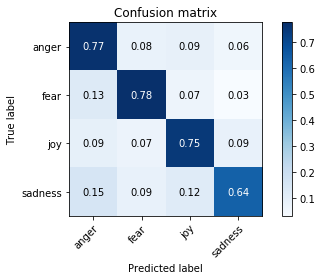

In [38]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### CNN

In [ ]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/cnn_100_30_ne/cnn_100_30_02-0.5082.h5').resolve()

In [ ]:
model = cnn_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### LSTM-CNN

In [ ]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/lstm_conv_100_30_ne/lstm_conv_100_30_03-0.5056.h5').resolve()

In [ ]:
start = time()
model = lstm_conv_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

### 200d

In [43]:
embedding_dim = 200

#### LSTM

In [44]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/lstm_200_30_ne/lstm_200_30_02-0.5120.h5').resolve()

In [49]:
start = time()
model = lstm_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 3.19 secs
              precision    recall  f1-score   support

           0     0.7436    0.7341    0.7388      1892
           1     0.4764    0.7365    0.5786       630
           2     0.8972    0.7171    0.7971      3397
           3     0.5130    0.6884    0.5879      1059

    accuracy                         0.7191      6978
   macro avg     0.6576    0.7190    0.6756      6978
weighted avg     0.7593    0.7191    0.7298      6978



In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### CNN

In [ ]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/cnn_200_30_ne/cnn_200_30_02-0.5060.h5').resolve()

In [ ]:
start = time()
model = cnn_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)

#### LSTM-CNN

In [ ]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/emotion_recognition/checkpoints/lstm_conv_200_30_ne/lstm_conv_200_30_02-0.5104.h5').resolve()

In [ ]:
start = time()
model = lstm_conv_model(input_length, input_dim, 4, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=1)
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)